In [38]:
import numpy as np
#import gplately.pygplates as pygplates
import ptt
import gplately
import gplately.tools as tools
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader as shpreader
import netCDF4
import warnings
from scipy import ndimage
import glob, os
from rasterio.features import rasterize
from rasterio.transform import from_bounds
import matplotlib.gridspec as gridspec
#from slabdip import SlabDipper
import matplotlib
import pandas as pd
from cmcrameri import cm
#import gplately.pygplates as pygplates
import glob, os
import matplotlib.pyplot as plt
from plate_model_manager import PlateModelManager

from gplately import pygplates

import geopandas as gpd

# matplotlib.rcParams['font.family'] = 'Arial'
# matplotlib.rcParams['pdf.fonttype'] = 42
# matplotlib.rcParams.update({
#     "pdf.use14corefonts": True
# })

reconstruction_times = np.arange(0,1800,1)
extent_global = [-180,180,-90,90]

# Import 1.8Ga_model_optimised_mantle_ref_frame_20240725

In [39]:
use_local_files = True

if use_local_files:
    # Method 1: manually point to files
    input_directory = 'data/1.8Ga_model_optimised_mantle_ref_frame_20240725/1.8Ga_model_optimised_mantle_ref_frame_20240725'
    # Load rotation files
    rotation_filenames = glob.glob(os.path.join(input_directory, 'optimised_rotation_model_20240725_run3.rot'))
    rotation_model = pygplates.RotationModel(rotation_filenames)

    # Load static polygons
    static_polygons = pygplates.FeatureCollection(os.path.join(input_directory, 'static_polygons.gpmlz'))
    COBs = input_directory+'/COBfile_1800_0.gpml'
    # Load topology files and combine into a single FeatureCollection
    topology_filenames = [
        os.path.join(input_directory, '250-0_plate_boundaries.gpml'),
        os.path.join(input_directory, '410-250_plate_boundaries.gpml'),
        os.path.join(input_directory, '1800-1000_plate_boundaries.gpml'),
        os.path.join(input_directory, '1000-410_plate_boundaries.gpml'),
        os.path.join(input_directory, '1000-410-Convergence.gpml'),
        os.path.join(input_directory, '1000-410-Divergence.gpml'),
        #os.path.join(input_directory, '1000-410-Topologies.gpml'),
        os.path.join(input_directory, '1000-410-Transforms.gpml'),
        os.path.join(input_directory, 'TopologyBuildingBlocks.gpml'),
    ]
    
    # Create an empty list to hold all the features
    all_topology_features = []

    # Load each file and append its features to the list
    for topology_filename in topology_filenames:
        fc = pygplates.FeatureCollection(topology_filename)
        all_topology_features.extend(fc)

    # Create a single FeatureCollection from the combined features
    topology_features = pygplates.FeatureCollection(all_topology_features)

    # Optionally load other geological features if needed
    continents = pygplates.FeatureCollection(os.path.join(input_directory, 'shapes_continents.gpmlz'))
    COBs = pygplates.FeatureCollection(os.path.join(input_directory, 'COBfile_1800_0.gpml'))
    #Paleomagnetic_poles = pygplates.FeatureCollection(os.path.join(input_directory, 'Paleomagnetic_poles.gpml'))
    shapes_coasts = pygplates.FeatureCollection(os.path.join(input_directory, 'shapes_coasts.gpmlz'))
    #deposits = pygplates.FeatureCollection('/data/Craton_HS_2B_PLATEID1/Craton_Deposits_PLATEID1.gpml')

    # Create PlateReconstruction model
    model = gplately.PlateReconstruction(rotation_model=rotation_model, 
                                     topology_features=topology_features, 
                                     static_polygons=static_polygons)

    # Now you can proceed with your reconstruction and plotting...


C:\Users\Hojat\.conda\envs\gplately\lib\site-packages\gplately\pygplates.py:347: ImportWarning: 
FeatureCollection: No filename associated with <class 'list'> in __init__
 ensure pygplates is imported from gplately. Run,
 from gplately import pygplates


# Load Hoggard data

In [40]:
#shp

In [41]:
import geopandas as gpd
import pandas as pd
import gplately

# Read the shapefile into a GeoDataFrame
gdf = gpd.read_file('./outputs/segmented_craton_features.shp')  # Replace with the actual path to your shapefile

# Dictionary to hold DataFrames for each type
metal_dict = dict()

# List of commodities (not used in the filtering, just for reference)
commodities = ['Cu (Mt)', 'Pb (Mt)', 'Zn (Mt)', 'Ni (Mt)']

# Get unique types from the 'Type' column
types = gdf['Type'].unique()

# Filter data by type
for type_name in types:
    df = gdf[gdf['Type'] == type_name]
    
    # Ensure that the 'Age' column is present and filter data
    if 'Age' in df.columns:
        df = df[df['Age'].notna()]
        df = df[df['Age'] > 0]  # Remove rows where Age = 0
        df = df[df['Age'] <= 1800]
        
        if df.shape[0] > 0:
            metal_dict[type_name] = df

# Process the filtered data
pts_dict = dict()
for i, t in enumerate(types):
    df = metal_dict[t]
    
    # Extract Lon/Lat from the geometry column and create points for gplately
    pts_dict[t] = gplately.Points(model, df['geometry'].x, df['geometry'].y)

# You can now proceed with the rest of your code (e.g., plotting symbols)
symbols = ['o', 'v', 's', '*', 'd', '^', 'P']*2


# Load craton database

In [42]:
reconstruction_time_map = 50

In [43]:
### Load craton database
Craton_HS_filename = "data/segmented_craton_rift/merged_segmented_craton.shp"
Craton_HS_features = pygplates.FeatureCollection(Craton_HS_filename)
reconstructed_Craton_HS_features = model.reconstruct(Craton_HS_features, reconstruction_time_map)
#deposits = '/data/Craton_HS_2B_PLATEID1/Craton_Deposits_PLATEID1.gpml'

## Reconstruct Craton

In [44]:
from scipy.spatial import cKDTree

def KD_dist(lons0, lats0, lons1, lats1, k=1):
    """ Function to efficiently query nearest-neighbour distances """
    x0, y0, z0 = gplately.tools.lonlat2xyz(lons0, lats0)
    x1, y1, z1 = gplately.tools.lonlat2xyz(lons1, lats1)
    
    tree = cKDTree(np.c_[x0, y0, z0])
    d, idx = tree.query(np.c_[x1, y1, z1], k=k)
    return d*gplately.EARTH_RADIUS, idx

In [45]:
# Initialize unique_times as a set to collect unique ages
unique_times = set()

# Loop over each type in types
for i, type_name in enumerate(types):
    df = metal_dict[type_name]
    
    # Collect unique ages from each type and update the set
    unique_times = unique_times.union(set(df['Age'].to_numpy(dtype=int)))

    # Subduction zone attributes
    df['subduction_length'] = 0.0
    df['Length'] = 0.0


    # Store the updated dataframe back in the metal_dict
    metal_dict[type_name] = df


# Extracting Plate Tectonic Features at Formation Time

In [46]:
def segmentise_boundaries(subduction_lon, subduction_lat):
    
    earth_radius = 6371

    dtol = tessellation_threshold_radians*earth_radius + 5.0 # km
    segment_IDs = np.zeros(len(subduction_lon), dtype=int)

    index = 1
    for i in range(0, len(subduction_lon)-1):
        lon0 = subduction_lon[i]
        lat0 = subduction_lat[i]
        lon1 = subduction_lon[i+1]
        lat1 = subduction_lat[i+1]

        # distance between points (convert to unit sphere)
        
        xs, ys, zs = gplately.tools.lonlat2xyz([lon0,lon1], [lat0,lat1])
        dist = np.sqrt((xs[1]-xs[0])**2 + (ys[1]-ys[0])**2 + (zs[1]-zs[0])**2) * earth_radius

        if dist < dtol:
            # add to current segment
            segment_IDs[i] = index

        elif np.count_nonzero(segment_IDs == index) > 1:
            segment_IDs[i] = index
            index += 1
        else:
            pass

    unique_segment_IDs = set(segment_IDs)
    unique_segment_IDs.remove(0)
    return segment_IDs, unique_segment_IDs

In [47]:
for t, time in enumerate(unique_times):
    # Tessellate subduction zones for the current time
    subduction_data = model.tessellate_subduction_zones(time, np.deg2rad(0.5), ignore_warnings=True)

#subduction_data = model.tessellate_subduction_zones(time, np.deg2rad(0.5), ignore_warnings=True)
    
# Extract longitude and latitude for subduction zones
subduction_lon = subduction_data[:, 0]
subduction_lat = subduction_data[:, 1]

tessellation_threshold_radians = np.deg2rad(0.5)


In [48]:
segment_IDs, unique_segment_IDs = segmentise_boundaries(subduction_lon, subduction_lat)

In [49]:
def segmentise_boundaries(subduction_lon, subduction_lat, tessellation_threshold_radians):
    earth_radius = 6371  # Earth radius in km
    dtol = tessellation_threshold_radians * earth_radius + 5.0  # Distance tolerance in km
    segment_IDs = np.zeros(len(subduction_lon), dtype=int)

    index = 1
    for i in range(0, len(subduction_lon) - 1):
        lon0 = subduction_lon[i]
        lat0 = subduction_lat[i]
        lon1 = subduction_lon[i + 1]
        lat1 = subduction_lat[i + 1]

        # Distance between points (convert to unit sphere)
        xs, ys, zs = gplately.tools.lonlat2xyz([lon0, lon1], [lat0, lat1])
        dist = np.sqrt((xs[1] - xs[0]) ** 2 + (ys[1] - ys[0]) ** 2 + (zs[1] - zs[0]) ** 2) * earth_radius

        if dist < dtol:
            # Add to current segment
            segment_IDs[i] = index
        elif np.count_nonzero(segment_IDs == index) > 1:
            segment_IDs[i] = index
            index += 1
        else:
            pass

    unique_segment_IDs = set(segment_IDs)
    if 0 in unique_segment_IDs:
        unique_segment_IDs.remove(0)
    
    return segment_IDs, unique_segment_IDs


# Now for the full code with subduction segmentation and length calculation
for t, time in enumerate(unique_times):
    # Tessellate subduction zones for the current time
    subduction_data = model.tessellate_subduction_zones(time, np.deg2rad(0.5), ignore_warnings=True)

    # Extract longitude and latitude for subduction zones
    subduction_lon = subduction_data[:, 0]
    subduction_lat = subduction_data[:, 1]

    # Segmentize subduction boundaries using the updated function
    tessellation_threshold_radians = np.deg2rad(0.5)
    segment_IDs, unique_segment_IDs = segmentise_boundaries(subduction_lon, subduction_lat, tessellation_threshold_radians)

    # Calculate subduction length for each segment based on the formula you provided
    subduction_length = np.deg2rad(subduction_data[:, 6]) * gplately.EARTH_RADIUS  # Subduction lengths in kilometers

    # Create a dictionary to store the total subduction length for each segment
    segment_length_dict = {}
    for seg_id in np.unique(segment_IDs):
        mask = segment_IDs == seg_id
        total_length = subduction_length[mask].sum()
        segment_length_dict[seg_id] = total_length

    # Continue with the rest of the analysis, e.g., deposit analysis, nearest subduction calculation, etc.
    sx, sy, sz = gplately.tools.lonlat2xyz(subduction_lon, subduction_lat)
    tree_sz = cKDTree(np.c_[sx, sy, sz])  # Create KDTree for nearest neighbor search

    # Iterate over each mineral type
    for type_name in types:
        df = metal_dict[type_name]
        deposit_age = df['Age'].to_numpy(dtype=int)
        mask_deposit_ages = deposit_age == time
        index_deposit_age = df.index[mask_deposit_ages]

        if not index_deposit_age.any():
            continue

        gpts = pts_dict[type_name]
        rlons, rlats = gpts.reconstruct(time, return_array=True)

        valid_mask = (rlats >= -90) & (rlons >= -180)
        rlons, rlats = rlons[valid_mask], rlats[valid_mask]

        if len(rlats) == 0 or len(rlons) == 0:
            continue

        # Find nearest subduction zone segment for each deposit
        rx, ry, rz = gplately.tools.lonlat2xyz(rlons, rlats)
        d2s, sz_neighbours = tree_sz.query(np.c_[rx, ry, rz])

        for d2r, neighbour, index in zip(d2s, sz_neighbours, index_deposit_age):
            # Get the segment ID and length for the nearest subduction zone
            nearest_segment_id = segment_IDs[neighbour]
            nearest_segment_length = segment_length_dict[nearest_segment_id]

            # Update the DataFrame with the subduction segment length
            df.loc[index, 'sub_len'] = nearest_segment_length

            # (Rest of your code to compute other deposit-subduction zone properties)

    # Update progress
    gplately.tools.update_progress((t + 1) / len(unique_times))


Progress: [####################] 100.0%


In [50]:
# Checking

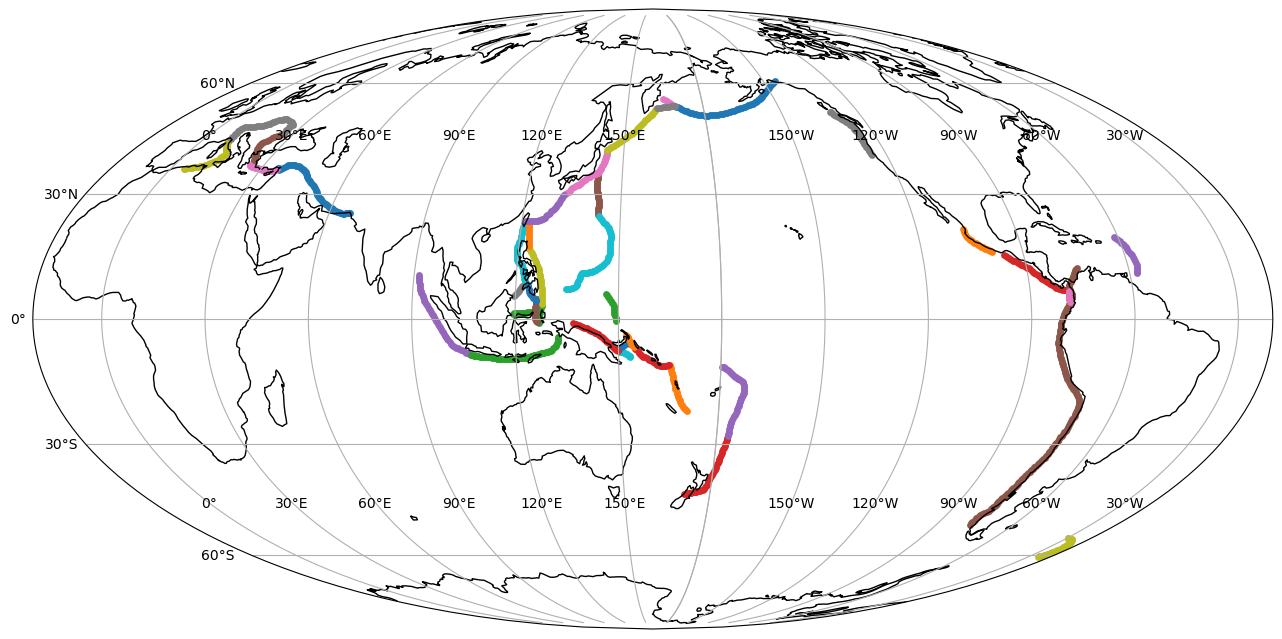

In [51]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

# Assuming '0' is the present day in unique_times
present_day_time = 0

# Tessellate subduction zones for the present day
subduction_data = model.tessellate_subduction_zones(present_day_time, np.deg2rad(0.5), ignore_warnings=True)

# Extract longitude and latitude for subduction zones
subduction_lon = subduction_data[:, 0]
subduction_lat = subduction_data[:, 1]

# Segmentize subduction boundaries
tessellation_threshold_radians = np.deg2rad(0.5)
segment_IDs, unique_segment_IDs = segmentise_boundaries(subduction_lon, subduction_lat, tessellation_threshold_radians)

# Plot subduction segments colored by their segment ID
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude=160))
ax.set_global()

# Loop through each segment and plot with corresponding color
for i, seg_ID in enumerate(unique_segment_IDs):
    mask_segment = segment_IDs == seg_ID
    
    # Scatter plot for each segment with unique colors
    ax.scatter(subduction_lon[mask_segment],
               subduction_lat[mask_segment],
               label=f'Segment {seg_ID}',  # Label with segment ID
               c=f'C{i % 10}',  # Cycle through 10 colors ('C0' to 'C9')
               s=15, 
               transform=ccrs.PlateCarree())  # Project lon/lat using PlateCarree

# Add coastlines for reference
ax.coastlines()

# Add gridlines with labels for longitude and latitude
gl = ax.gridlines(draw_labels=True, xlocs=np.arange(-180, 181, 30), ylocs=np.arange(-90, 91, 30))
gl.top_labels = False  # Disable top labels
gl.right_labels = False  # Disable right labels

# Add a legend to identify each segment by its ID
# ax.legend(loc='lower left', bbox_to_anchor=(0.0, 0.0), fontsize='small', ncol=2)

# Display the plot
plt.show()


## Histograms (No.)

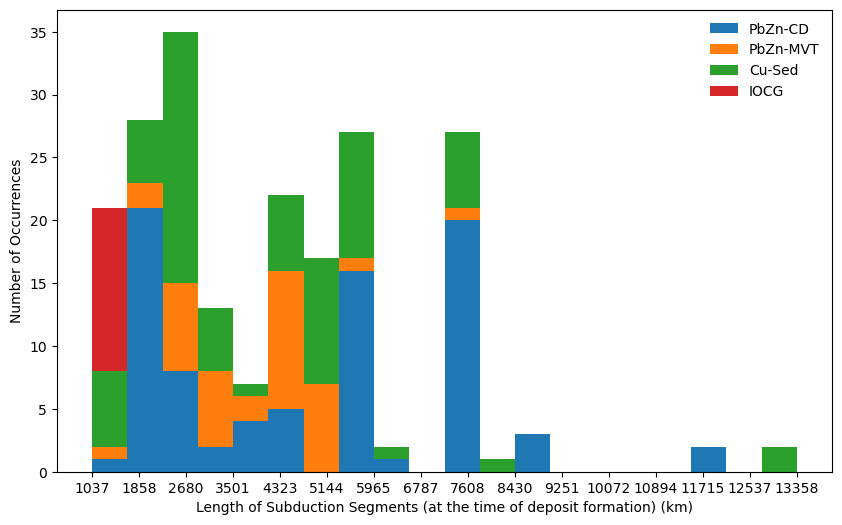

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# Define custom labels for each variable
custom_labels = {
    "sub_len": "Length of Subduction Segments (at the time of deposit formation) (km)",
}

# Loop over the variables for plotting
for label in [
    "sub_len",
]:
    # Set the figure size
    fig = plt.figure(figsize=(10, 6))
    ax1 = fig.add_subplot(111)

    # Set custom axis labels using the dictionary
    ax1.set_xlabel(custom_labels[label])
    ax1.set_ylabel('Number of Occurrences')

    variable_stack = []
    vmin = float('inf')
    vmax = float('-inf')

    for type_name in types:
        df = metal_dict[type_name]

        # Replace inf with nan
        df = df.replace(np.inf, np.nan)
        variable_stack.append(df[label])

        # Calculate percentiles for vmin and vmax, handling NaNs properly
        current_vmin = np.nanpercentile(df[label], 1)
        current_vmax = np.nanpercentile(df[label], 99)

        vmin = min(vmin, current_vmin)
        vmax = max(vmax, current_vmax)

    # Update vmin and vmax based on data range (removing the 0 lower bound constraint)
    # We use vmin without enforcing 0, so it dynamically adjusts to the minimum of the data
    vmin = vmin  # No enforcement of vmin = 0

    # Plot the stacked histogram with custom bins
    ax1.hist(variable_stack, bins=20, range=(vmin, vmax), stacked=True, label=types)
    ax1.legend(loc="upper right", frameon=False)

    # Set the step size to create evenly spaced ticks
    step_size = (vmax - vmin) / 15  # Adjust step size based on data range
    x_ticks = np.arange(vmin, vmax + step_size, step=step_size)  # Generate tick positions
    ax1.set_xticks(x_ticks)  # Set custom x-tick positions

    # Conditional formatting for tick labels: show 2 decimals for -1 < tick < 1, otherwise no decimals
    ax1.set_xticklabels([f'{tick:.2f}' if -1 < tick < 1 else f'{tick:.0f}' for tick in x_ticks])

    # Show the plot for each iteration
    plt.show()


## Weighted Histograms

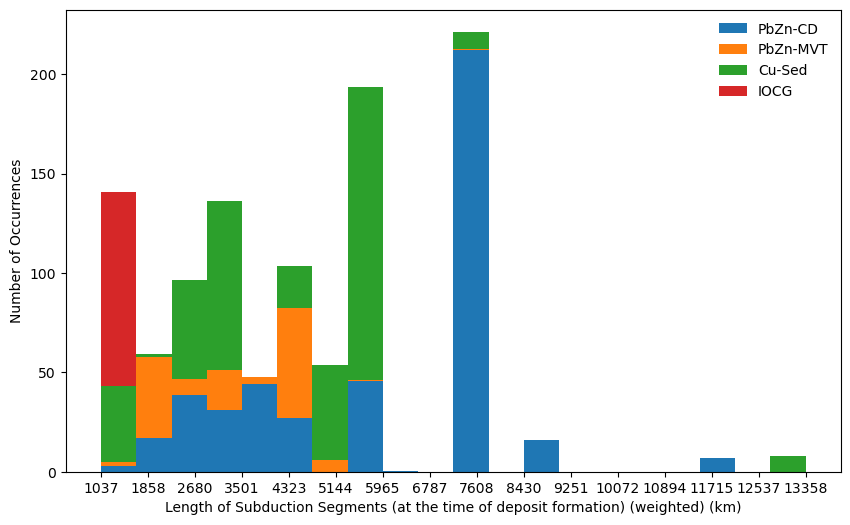

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# Define custom labels for each variable
custom_labels = {
    "sub_len": "Length of Subduction Segments (at the time of deposit formation) (weighted) (km)",
    # Add more labels as needed
}

# Loop over the variables for plotting
for label in [
    "sub_len",  # Add more variables as needed
]:
    # Set the figure size (you can adjust this size)
    fig = plt.figure(figsize=(10, 6))
    ax1 = fig.add_subplot(111)

    # Set custom axis labels using the dictionary
    ax1.set_xlabel(custom_labels.get(label, label))  # Use label from the dictionary or fallback to the variable name
    ax1.set_ylabel('Number of Occurrences')

    variable_stack = []
    weight_stack = []
    vmin = float('inf')
    vmax = float('-inf')

    for type_name in types:
        df = metal_dict[type_name]

        # Replace inf with nan
        df = df.replace(np.inf, np.nan)

        # Get the variable and weights
        variable = df[label].to_numpy()
        weights = df['TM2'].to_numpy()  # Use TM2 column as weights

        variable_stack.append(variable)
        weight_stack.append(weights)

        # Calculate percentiles for vmin and vmax, handling NaNs properly
        current_vmin = np.nanpercentile(variable, 1)
        current_vmax = np.nanpercentile(variable, 99)

        vmin = min(vmin, current_vmin)
        vmax = max(vmax, current_vmax)

    # Update vmin and vmax based on data range
    vmin = vmin  # No enforcement of vmin = 0

    # Plotting the stacked weighted histogram with custom bins
    ax1.hist(variable_stack, bins=20, range=(vmin, vmax), weights=weight_stack, stacked=True, label=types)
    ax1.legend(loc="upper right", frameon=False)

    # Set the step size to create evenly spaced ticks
    step_size = (vmax - vmin) / 15  # Divides the range into 15 equal intervals
    x_ticks = np.arange(vmin, vmax + step_size, step=step_size)  # Generate tick positions
    ax1.set_xticks(x_ticks)  # Set custom x-tick positions

    # Conditional formatting for tick labels: show 2 decimals for -1 < tick < 1, otherwise no decimals
    ax1.set_xticklabels([f'{tick:.2f}' if -1 < tick < 1 else f'{tick:.0f}' for tick in x_ticks])

# Show the plot for each iteration
plt.show()


# Over a a-million-year period (Median)

## Extracting Plate Tectonic Features (a-Million-year)

In [54]:
import numpy as np
from scipy.spatial import cKDTree
a = 20
def segmentise_boundaries(subduction_lon, subduction_lat, tessellation_threshold_radians):
    earth_radius = 6371  # Earth radius in km
    dtol = tessellation_threshold_radians * earth_radius + 5.0  # Distance tolerance in km
    segment_IDs = np.zeros(len(subduction_lon), dtype=int)

    index = 1
    for i in range(0, len(subduction_lon) - 1):
        lon0 = subduction_lon[i]
        lat0 = subduction_lat[i]
        lon1 = subduction_lon[i + 1]
        lat1 = subduction_lat[i + 1]

        # Distance between points (convert to unit sphere)
        xs, ys, zs = gplately.tools.lonlat2xyz([lon0, lon1], [lat0, lat1])
        dist = np.sqrt((xs[1] - xs[0]) ** 2 + (ys[1] - ys[0]) ** 2 + (zs[1] - zs[0]) ** 2) * earth_radius

        if dist < dtol:
            # Add to current segment
            segment_IDs[i] = index
        elif np.count_nonzero(segment_IDs == index) > 1:
            segment_IDs[i] = index
            index += 1
        else:
            pass

    unique_segment_IDs = set(segment_IDs)
    if 0 in unique_segment_IDs:
        unique_segment_IDs.remove(0)
    
    return segment_IDs, unique_segment_IDs


# Main code to calculate median subduction length
years_to_check = a  # Number of years to look back for median calculation

for t, time in enumerate(unique_times):
    # Tessellate subduction zones for the current time
    subduction_data = model.tessellate_subduction_zones(time, np.deg2rad(0.5), ignore_warnings=True)

    # Extract longitude and latitude for subduction zones
    subduction_lon = subduction_data[:, 0]
    subduction_lat = subduction_data[:, 1]

    # Segmentize subduction boundaries using the updated function
    tessellation_threshold_radians = np.deg2rad(0.5)
    segment_IDs, unique_segment_IDs = segmentise_boundaries(subduction_lon, subduction_lat, tessellation_threshold_radians)

    # Calculate subduction length for each segment based on the formula you provided
    subduction_length = np.deg2rad(subduction_data[:, 6]) * gplately.EARTH_RADIUS  # Subduction lengths in kilometers

    # Prepare KDTree for nearest neighbor search
    sx, sy, sz = gplately.tools.lonlat2xyz(subduction_lon, subduction_lat)
    tree_sz = cKDTree(np.c_[sx, sy, sz])  # Create KDTree for nearest neighbor search

    # Iterate over each mineral type
    for type_name in types:
        df = metal_dict[type_name]
        deposit_age = df['Age'].to_numpy(dtype=int)
        mask_deposit_ages = deposit_age == time
        index_deposit_age = df.index[mask_deposit_ages]

        if not index_deposit_age.any():
            continue

        gpts = pts_dict[type_name]
        rlons, rlats = gpts.reconstruct(time, return_array=True)

        valid_mask = (rlats >= -90) & (rlons >= -180)
        rlons, rlats = rlons[valid_mask], rlats[valid_mask]

        if len(rlats) == 0 or len(rlons) == 0:
            continue

        # Find nearest subduction zone segment for each deposit
        rx, ry, rz = gplately.tools.lonlat2xyz(rlons, rlats)
        d2s, sz_neighbours = tree_sz.query(np.c_[rx, ry, rz])

        # Initialize a list to store subduction segment lengths over the last a years
        subduction_lengths_over_time = []

        # Loop to get subduction lengths for the past a years
        for year_offset in range(1, years_to_check + 1):
            avg_time = time - year_offset  # 1 year back, 2 years back, a years back

            # Tessellate subduction zones for the past time step
            subduction_data = model.tessellate_subduction_zones(avg_time, np.deg2rad(0.5), ignore_warnings=True)
            subduction_lon = subduction_data[:, 0]
            subduction_lat = subduction_data[:, 1]

            # Segmentize subduction boundaries
            segment_IDs, unique_segment_IDs = segmentise_boundaries(subduction_lon, subduction_lat, tessellation_threshold_radians)

            # Calculate subduction length for each segment
            subduction_length = np.deg2rad(subduction_data[:, 6]) * gplately.EARTH_RADIUS  # Subduction lengths in kilometers

            # Collect subduction lengths for this year, with bounds checking
            for d2r, neighbour in zip(d2s, sz_neighbours):
                if neighbour < len(segment_IDs):  # Bounds check for segment_IDs
                    nearest_segment_id = segment_IDs[neighbour]
                    if nearest_segment_id in segment_IDs:
                        nearest_segment_length = subduction_length[segment_IDs == nearest_segment_id].sum()
                        subduction_lengths_over_time.append(nearest_segment_length)

        # Calculate the median subduction length over the past a years
        if subduction_lengths_over_time:
            median_subduction_length_a_years = np.median(subduction_lengths_over_time)
            df.loc[index_deposit_age, 'sub_len_m'] = median_subduction_length_a_years

    # Update progress
    gplately.tools.update_progress((t + 1) / len(unique_times))


Progress: [####################] 100.0%


## Histograms (No.)

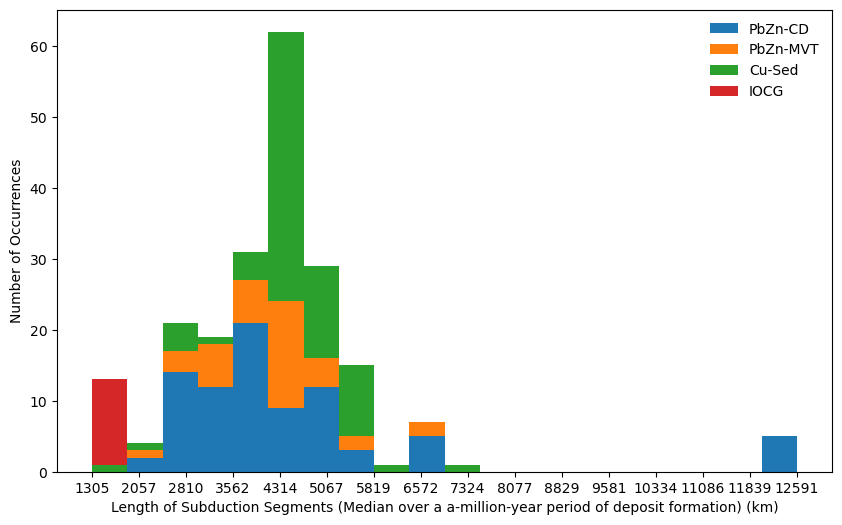

In [55]:
import numpy as np
import matplotlib.pyplot as plt

# Define custom labels for each variable
custom_labels = {
    "sub_len_m": "Length of Subduction Segments (Median over a a-million-year period of deposit formation) (km)",
}

# Loop over the variables for plotting
for label in [
    "sub_len_m",
]:
    # Set the figure size
    fig = plt.figure(figsize=(10, 6))
    ax1 = fig.add_subplot(111)

    # Set custom axis labels using the dictionary
    ax1.set_xlabel(custom_labels[label])
    ax1.set_ylabel('Number of Occurrences')

    variable_stack = []
    vmin = float('inf')
    vmax = float('-inf')

    for type_name in types:
        df = metal_dict[type_name]

        # Replace inf with nan
        df = df.replace(np.inf, np.nan)
        variable_stack.append(df[label])

        # Calculate percentiles for vmin and vmax, handling NaNs properly
        current_vmin = np.nanpercentile(df[label], 1)
        current_vmax = np.nanpercentile(df[label], 99)

        vmin = min(vmin, current_vmin)
        vmax = max(vmax, current_vmax)

    # Update vmin and vmax based on data range (removing the 0 lower bound constraint)
    # We use vmin without enforcing 0, so it dynamically adjusts to the minimum of the data
    vmin = vmin  # No enforcement of vmin = 0

    # Plot the stacked histogram with custom bins
    ax1.hist(variable_stack, bins=20, range=(vmin, vmax), stacked=True, label=types)
    ax1.legend(loc="upper right", frameon=False)

    # Set the step size to create evenly spaced ticks
    step_size = (vmax - vmin) / 15  # Adjust step size based on data range
    x_ticks = np.arange(vmin, vmax + step_size, step=step_size)  # Generate tick positions
    ax1.set_xticks(x_ticks)  # Set custom x-tick positions

    # Conditional formatting for tick labels: show 2 decimals for -1 < tick < 1, otherwise no decimals
    ax1.set_xticklabels([f'{tick:.2f}' if -1 < tick < 1 else f'{tick:.0f}' for tick in x_ticks])

    # Show the plot for each iteration
    plt.show()


## Weighted Histograms

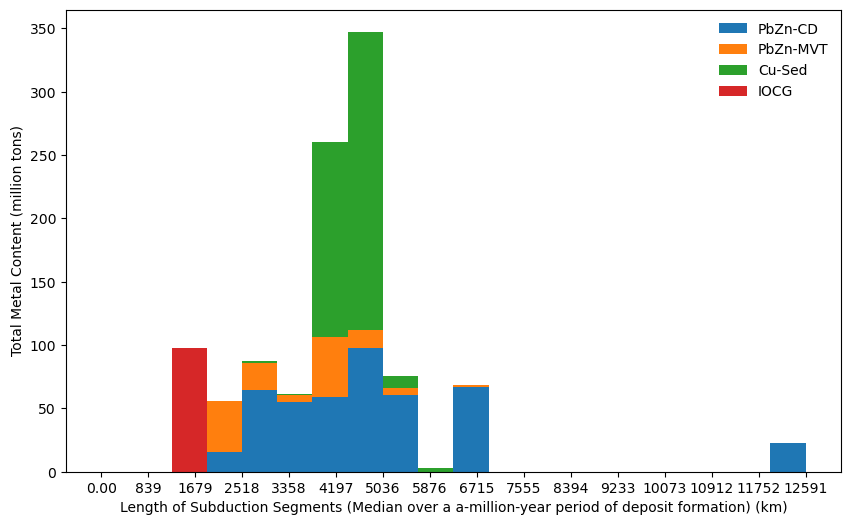

In [56]:
import numpy as np
import matplotlib.pyplot as plt

# Define custom labels for each variable
custom_labels = {
    "sub_len_m": "Length of Subduction Segments (Median over a a-million-year period of deposit formation) (km)",

}

# Loop over the variables for plotting
for label in [
    "sub_len_m"
]:
    # Set the figure size (you can adjust this size)
    fig = plt.figure(figsize=(10, 6))
    ax1 = fig.add_subplot(111)

    # Set custom axis labels using the dictionary
    ax1.set_xlabel(custom_labels[label])
    ax1.set_ylabel('Total Metal Content (million tons)')
    variable_stack = []
    weight_stack = []
    vmin = float('inf')
    vmax = float('-inf')

    for type_name in types:
        df = metal_dict[type_name]

        # Replace inf with nan
        df = df.replace(np.inf, np.nan)

        # Get the variable and weights
        variable = df[label].to_numpy()
        weights = df['TM2'].to_numpy()  # Use TM2 column as weights

        variable_stack.append(variable)
        weight_stack.append(weights)

        # Calculate percentiles for vmin and vmax, handling NaNs properly
        current_vmin = np.nanpercentile(variable, 1)
        current_vmax = np.nanpercentile(variable, 99)

        vmin = min(vmin, current_vmin)
        vmax = max(vmax, current_vmax)

    # Ensure that vmin is 0 or lower (for including negative values)
    vmin = min(vmin, 0)

    # Plotting the stacked weighted histogram with custom bins
    ax1.hist(variable_stack, bins=20, range=(vmin, vmax), weights=weight_stack, stacked=True, label=types)
    ax1.legend(loc="upper right", frameon=False)

    # Set the step size to create evenly spaced ticks and ensure the ticks start from 0
    step_size = (vmax - vmin) / 15  # Divides the range into 15 equal intervals
    x_ticks = np.arange(vmin, vmax + step_size, step=step_size)  # Generate tick positions
    ax1.set_xticks(x_ticks)  # Set custom x-tick positions

    # Conditional formatting for tick labels: show 2 decimals for -1 < tick < 1, otherwise no decimals
    ax1.set_xticklabels([f'{tick:.2f}' if -1 < tick < 1 else f'{tick:.0f}' for tick in x_ticks])

# Show the plot for each iteration
plt.show()


# The Gradient or Change (g-million-year)

## Extracting Plate Tectonic Features (The Gradient)

In [57]:
import numpy as np
from scipy.spatial import cKDTree

g = 20  # Number of million years to calculate the gradient over

for t, time in enumerate(unique_times):
    # Tessellate subduction zones for the current time (Age)
    subduction_data = model.tessellate_subduction_zones(time, np.deg2rad(0.5), ignore_warnings=True)
    subduction_lon = subduction_data[:, 0]
    subduction_lat = subduction_data[:, 1]
    
    # Convert lon/lat to xyz coordinates for subduction zones
    sx, sy, sz = gplately.tools.lonlat2xyz(subduction_lon, subduction_lat)
    tree_sz = cKDTree(np.c_[sx, sy, sz])

    # Iterate over each mineral type
    for type_name in types:
        df = metal_dict[type_name]
        deposit_age = df['Age'].to_numpy(dtype=int)
        mask_deposit_ages = deposit_age == time
        index_deposit_age = df.index[mask_deposit_ages]

        if not index_deposit_age.any():
            continue

        gpts = pts_dict[type_name]
        rlons, rlats = gpts.reconstruct(time, return_array=True)

        # Apply strict validation for latitude and longitude values
        valid_mask = (rlats >= -90) & (rlats <= 90) & (rlons >= -180) & (rlons <= 180)
        rlons = rlons[valid_mask]
        rlats = rlats[valid_mask]

        if len(rlons) == 0 or len(rlats) == 0:
            print(f"No valid lat/lon points for {type_name} at time {time}")
            continue

        # Initialize lists to store subduction lengths over the years
        subduction_lengths = []

        # Loop for the g+1 years to calculate gradients
        for year_offset in range(g+1):  # To calculate gradients, we need g+1 years (including the current)
            avg_time = time - year_offset

            # Tessellate subduction zones for the current time step
            subduction_data = model.tessellate_subduction_zones(avg_time, np.deg2rad(0.5), ignore_warnings=True)
            subduction_lon = subduction_data[:, 0]
            subduction_lat = subduction_data[:, 1]

            # Convert lon/lat to xyz coordinates for subduction zones
            sx, sy, sz = gplately.tools.lonlat2xyz(subduction_lon, subduction_lat)
            tree_sz = cKDTree(np.c_[sx, sy, sz])

            # Calculate subduction lengths for this time step
            subduction_length = np.deg2rad(subduction_data[:, 6]) * gplately.EARTH_RADIUS  # Subduction lengths in kilometers

            # Collect the subduction length for this year
            subduction_lengths.append(np.sum(subduction_length))

        # Calculate gradients from g to 0 years
        if len(subduction_lengths) >= g+1:
            subduction_length_gradient_g_0 = (subduction_lengths[g] - subduction_lengths[0]) / 1

            # Update DataFrame with the gradient
            df.loc[index_deposit_age, 'sub_len_c'] = subduction_length_gradient_g_0

    # Update progress
    gplately.tools.update_progress((t + 1) / len(unique_times))


Progress: [####################] 100.0%


## Histograms (No.)

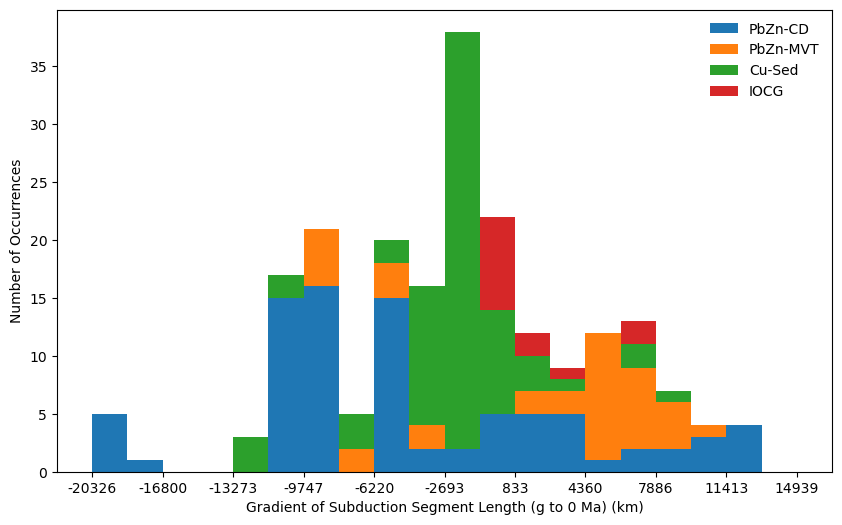

In [58]:
import numpy as np
import matplotlib.pyplot as plt

# Define custom labels for each variable
custom_labels = {
    "sub_len_c": "Gradient of Subduction Segment Length (g to 0 Ma) (km)",
}

# Loop over the variables for plotting
for label in [
    "sub_len_c",
]:
    # Set the figure size
    fig, ax1 = plt.subplots(figsize=(10, 6))  # Using plt.subplots for flexibility

    # Set custom axis labels using the dictionary
    ax1.set_xlabel(custom_labels.get(label, label))  # Use custom label or fallback to the key
    ax1.set_ylabel('Number of Occurrences')

    variable_stack = []
    vmin = float('inf')
    vmax = float('-inf')

    for type_name in types:
        df = metal_dict[type_name]

        # Check if the column exists before processing
        if label not in df.columns:
            print(f"Column '{label}' not found in DataFrame for {type_name}. Skipping...")
            continue

        # Replace inf with nan
        df = df.replace([np.inf, -np.inf], np.nan)
        variable_stack.append(df[label])

        # Calculate percentiles for vmin and vmax, handling NaNs properly
        current_vmin = np.nanpercentile(df[label], 1)
        current_vmax = np.nanpercentile(df[label], 99)

        vmin = min(vmin, current_vmin)
        vmax = max(vmax, current_vmax)

    # Update vmin and vmax based on data range
    if vmin == float('inf') or vmax == float('-inf'):
        print(f"No valid data to plot for {label}. Skipping this plot.")
        continue

    # Plot the stacked histogram with custom bins
    ax1.hist(variable_stack, bins=20, range=(vmin, vmax), stacked=True, label=types)
    ax1.legend(loc="upper right", frameon=False)

    # Set the step size to create evenly spaced ticks
    step_size = (vmax - vmin) / 10  # Adjust step size based on data range
    x_ticks = np.arange(vmin, vmax + step_size, step=step_size)  # Generate tick positions
    ax1.set_xticks(x_ticks)  # Set custom x-tick positions

    # Conditional formatting for tick labels: show 2 decimals for -1 < tick < 1, otherwise no decimals
    ax1.set_xticklabels([f'{tick:.2f}' if -1 < tick < 1 else f'{tick:.0f}' for tick in x_ticks])

    # Show the plot for each iteration
    plt.show()


## Weighted Histograms

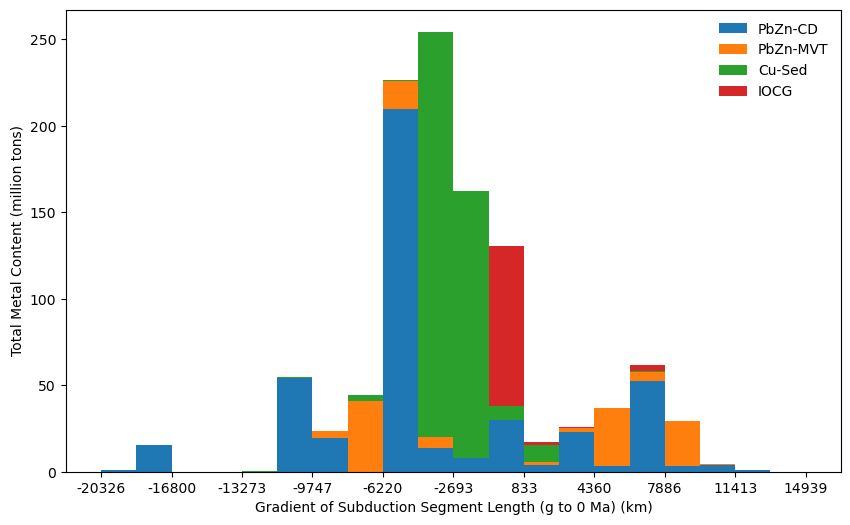

In [59]:
import numpy as np
import matplotlib.pyplot as plt

# Define custom labels for each variable
custom_labels = {
    "sub_len_c": "Gradient of Subduction Segment Length (g to 0 Ma) (km)",

}

# Loop over the variables for plotting
for label in [
    "sub_len_c"
]:
    # Set the figure size (you can adjust this size)
    fig = plt.figure(figsize=(10, 6))
    ax1 = fig.add_subplot(111)

    # Set custom axis labels using the dictionary
    ax1.set_xlabel(custom_labels[label])
    ax1.set_ylabel('Total Metal Content (million tons)')
    variable_stack = []
    weight_stack = []
    vmin = float('inf')
    vmax = float('-inf')

    for type_name in types:
        df = metal_dict[type_name]

        # Replace inf with nan
        df = df.replace(np.inf, np.nan)

        # Get the variable and weights
        variable = df[label].to_numpy()
        weights = df['TM2'].to_numpy()  # Use TM2 column as weights

        variable_stack.append(variable)
        weight_stack.append(weights)

        # Calculate percentiles for vmin and vmax, handling NaNs properly
        current_vmin = np.nanpercentile(variable, 1)
        current_vmax = np.nanpercentile(variable, 99)

        vmin = min(vmin, current_vmin)
        vmax = max(vmax, current_vmax)

    # Ensure that vmin is 0 or lower (for including negative values)
    vmin = min(vmin, 0)

    # Plotting the stacked weighted histogram with custom bins
    ax1.hist(variable_stack, bins=20, range=(vmin, vmax), weights=weight_stack, stacked=True, label=types)
    ax1.legend(loc="upper right", frameon=False)

    # Set the step size to create evenly spaced ticks and ensure the ticks start from 0
    step_size = (vmax - vmin) / 10  # Divides the range into 15 equal intervals
    x_ticks = np.arange(vmin, vmax + step_size, step=step_size)  # Generate tick positions
    ax1.set_xticks(x_ticks)  # Set custom x-tick positions

    # Conditional formatting for tick labels: show 2 decimals for -1 < tick < 1, otherwise no decimals
    ax1.set_xticklabels([f'{tick:.2f}' if -1 < tick < 1 else f'{tick:.0f}' for tick in x_ticks])

# Show the plot for each iteration
plt.show()


In [60]:
# export to csv

In [61]:
# Create an empty list to collect the data for all types
export_data = []

# Loop through each type and collect all data in the DataFrame
for type_name in types:
    df = metal_dict[type_name]
    
    # Add a column to indicate the type
    df['Type'] = type_name
    
    # Append the data for this type to the export_data list
    export_data.append(df)

# Concatenate all data into a single DataFrame
export_df = pd.concat(export_data, ignore_index=True)

# Export the combined DataFrame to a CSV file
export_df.to_csv('./outputs/segmented_craton_features_with_SL.csv', index=False)

print("segmented_craton_features_with_SL.csv")


segmented_craton_features_with_SL.csv


In [62]:
# export to shp

In [63]:
import geopandas as gpd

# Create an empty list to collect the data for all types
export_data = []

# Loop through each type and collect all data in the DataFrame
for type_name in types:
    df = metal_dict[type_name]
    
    # Add a column to indicate the type
    df['Type'] = type_name
    
    # Append the data for this type to the export_data list
    export_data.append(df)

# Concatenate all data into a single DataFrame
export_df = pd.concat(export_data, ignore_index=True)

# Ensure that the DataFrame has a geometry column
# (assuming your DataFrame already has a 'geometry' column with valid geometries)
gdf = gpd.GeoDataFrame(export_df, geometry='geometry')

# Export the combined GeoDataFrame to a shapefile
gdf.to_file('./outputs/segmented_craton_features_with_SL.shp', driver='ESRI Shapefile')

print("segmented_craton_features.shp")


segmented_craton_features.shp


C:\Users\Hojat\AppData\Local\Temp\ipykernel_21148\1008334848.py:24: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
C:\Users\Hojat\.conda\envs\gplately\lib\site-packages\pyogrio\raw.py:530: RuntimeWarning: Normalized/laundered field name: 'subduction_length' to 'subduction'


# Spearman correlation

## Weighted Spearman Correlation

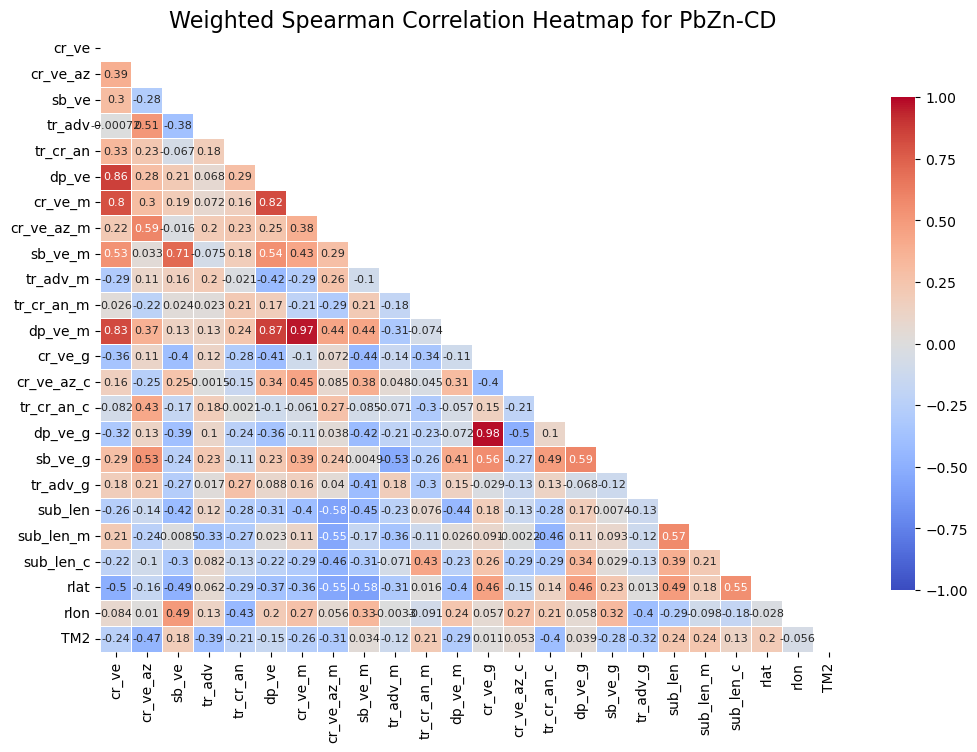

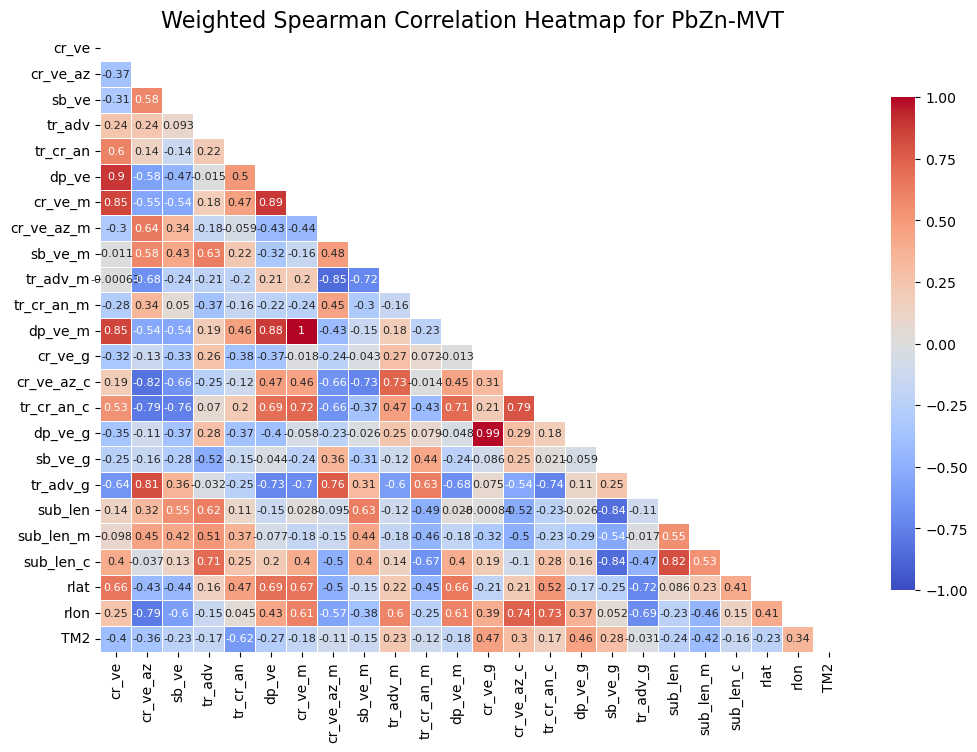

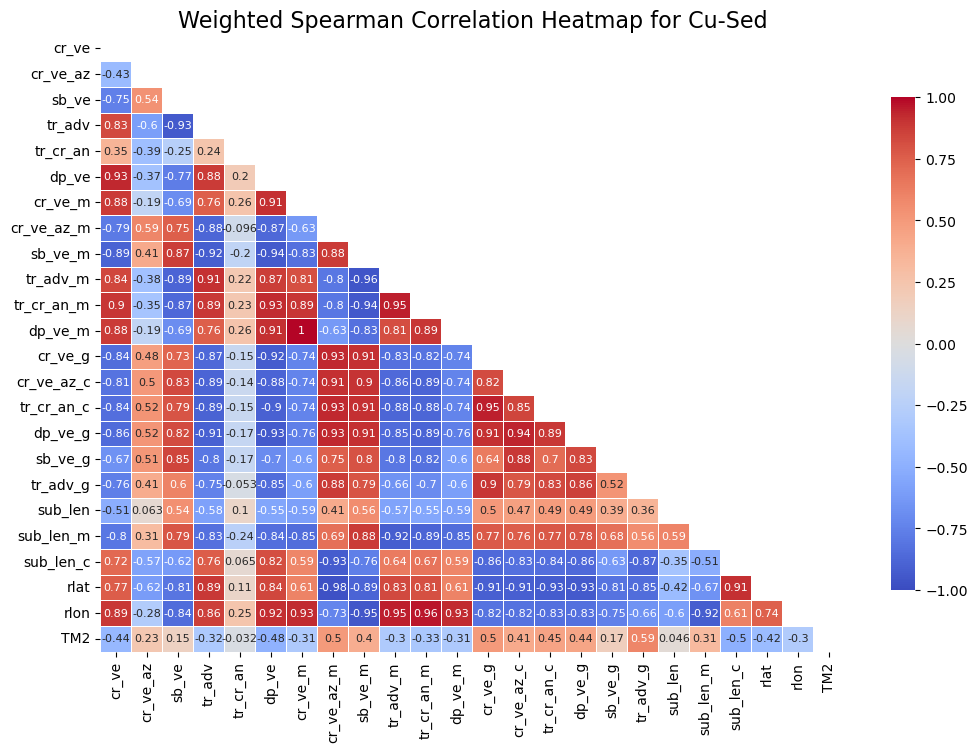

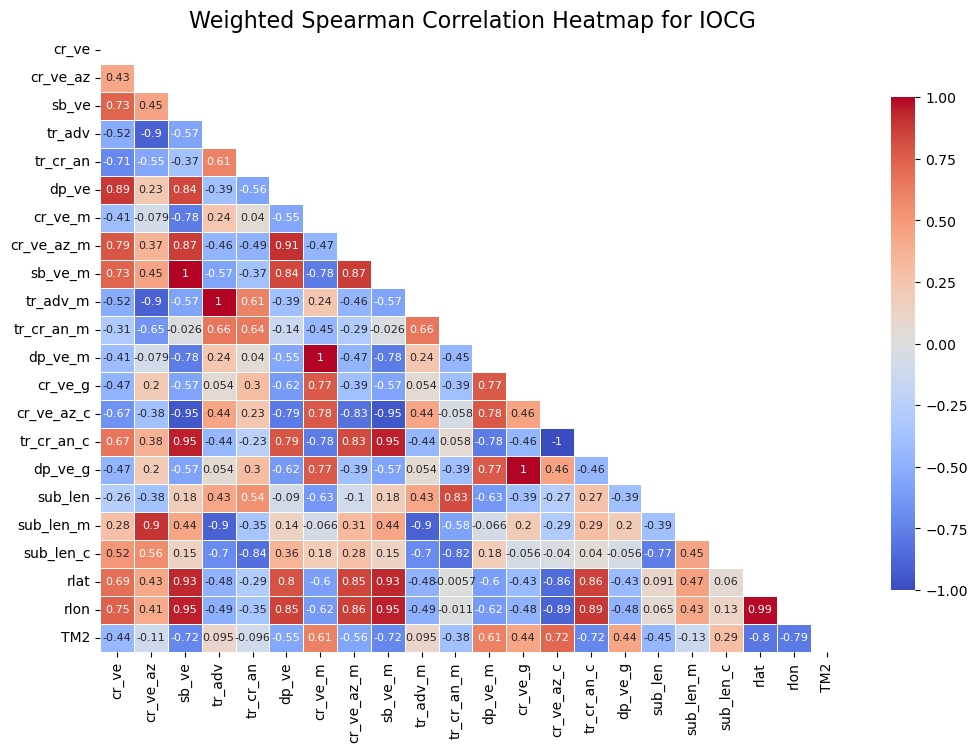

In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the combined data from the CSV file
export_df = pd.read_csv('./outputs/segmented_craton_features_with_SL.csv')

# Define the columns of interest for correlation
columns_of_interest = [
    'cr_ve', 'cr_ve_az', 
    'sb_ve', 'tr_adv', 
    'tr_cr_an', 'dp_ve',
    'cr_ve_m', 'cr_ve_az_m', 
    'sb_ve_m', 'tr_adv_m', 
    'tr_cr_an_m', 'dp_ve_m',
    'cr_ve_g', 'cr_ve_az_c',
    'tr_cr_an_c', 'dp_ve_g',
    'sb_ve_g', 'tr_adv_g',
    'sub_len',
    'sub_len_m', 'sub_len_c',
    'rlat', 'rlon', 'TM2'
]

# Function to compute weighted Spearman correlation
def weighted_spearmanr(x, y, weights):
    # Rank the data
    x_ranked = pd.Series(x).rank()
    y_ranked = pd.Series(y).rank()
    
    # Compute the weighted means of the ranked data
    wx_mean = np.average(x_ranked, weights=weights)
    wy_mean = np.average(y_ranked, weights=weights)
    
    # Compute the weighted covariance
    cov_xy = np.average((x_ranked - wx_mean) * (y_ranked - wy_mean), weights=weights)
    
    # Compute the weighted standard deviations
    wx_std = np.sqrt(np.average((x_ranked - wx_mean)**2, weights=weights))
    wy_std = np.sqrt(np.average((y_ranked - wy_mean)**2, weights=weights))
    
    # Return the weighted Spearman correlation
    return cov_xy / (wx_std * wy_std)

# Group the data by the 'Type' column
types = export_df['Type'].unique()

# Loop over the deposit types in the 'Type' column
for type_name in types:
    df = export_df[export_df['Type'] == type_name]  # Filter data for the current type

    # Handle missing values by dropping rows with NaN in the columns of interest
    df = df.dropna(subset=columns_of_interest)
    
    # Check for columns with zero variance and drop them
    zero_variance_cols = df[columns_of_interest].loc[:, df[columns_of_interest].std() == 0].columns
    df = df.drop(columns=zero_variance_cols, errors='ignore')
    
    # Ensure that all required columns are present and not empty
    remaining_columns = [col for col in columns_of_interest if col in df.columns and df[col].std() != 0]
    
    if len(remaining_columns) < 2:
        print(f"Skipping {type_name} due to insufficient non-zero variance columns.")
        continue
    
    # Extract the weights
    weights = df['TM2'].to_numpy()

    # Compute pairwise weighted Spearman correlations for the remaining columns of interest
    corr_matrix = pd.DataFrame(index=remaining_columns, columns=remaining_columns)

    for col1 in remaining_columns:
        for col2 in remaining_columns:
            # Compute weighted Spearman correlation for each pair
            if col1 != col2:
                corr_matrix.loc[col1, col2] = weighted_spearmanr(df[col1], df[col2], weights)
            else:
                corr_matrix.loc[col1, col2] = 1  # Correlation with itself is always 1

    # Mask the upper triangle of the heatmap
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    # Plot the correlation matrix as a heatmap
    plt.figure(figsize=(12, 8))
    plt.title(f"Weighted Spearman Correlation Heatmap for {type_name}", fontsize=16)
    
    # Plot the heatmap with the upper-right half masked
    sns.heatmap(corr_matrix.astype(float), annot=True, cmap="coolwarm", vmin=-1, vmax=1, center=0, 
                annot_kws={"size": 8}, linewidths=.5, cbar_kws={"shrink": 0.8}, mask=mask)
    
    # Show the heatmap for each deposit type separately
    plt.show()


## Pairplots (Weighted)

In [65]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the combined data from the CSV file
export_df = pd.read_csv('./outputs/segmented_craton_features_with_SL.csv')

# Define the columns of interest
columns_of_interest = [
    'cr_ve', 'cr_ve_az', 
    'sb_ve', 'tr_adv', 
    'tr_cr_an', 'dp_ve',
    'cr_ve_m', 'cr_ve_az_m', 
    'sb_ve_m', 'tr_adv_m', 
    'tr_cr_an_m', 'dp_ve_m',
    'cr_ve_g', 'cr_ve_az_c',
    'tr_cr_an_c', 'dp_ve_g',
    'sb_ve_g', 'tr_adv_g',
    'sub_len',
    'sub_len_m', 'sub_len_c',
    'rlat', 'rlon',
]

# Group the data by the 'Type' column in your combined DataFrame
types = export_df['Type'].unique()

# Loop over the deposit types in the 'Type' column
for type_name in types:
    # Filter the DataFrame for the current deposit type
    df_type = export_df[export_df['Type'] == type_name]

    # Filter the DataFrame to keep only the columns of interest and drop rows with missing values
    df_clean = df_type[columns_of_interest + ['TM2']].dropna()

    if df_clean.empty:
        print(f"No data available for {type_name}")
        continue

    # Drop columns with zero variance (all values are the same)
    zero_variance_cols = df_clean.columns[df_clean.nunique() <= 1]
    df_clean = df_clean.drop(columns=zero_variance_cols)

    if df_clean.empty:
        print(f"All columns for {type_name} have zero variance or missing values, skipping.")
        continue

    # Normalize the 'TM2' column for use in point sizes
    df_clean['TM2_normalized'] = (df_clean['TM2'] - df_clean['TM2'].min()) / (df_clean['TM2'].max() - df_clean['TM2'].min())
    df_clean['TM2_normalized'] = df_clean['TM2_normalized'].fillna(1)  # Ensure no NaN values for point sizes
    
    # Custom function to handle weighted scatterplot in pairplot
    def weighted_scatter(x, y, **kwargs):
        sizes = df_clean['TM2_normalized'] * 200  # Multiply to scale sizes
        plt.scatter(x, y, s=sizes, alpha=0.6, edgecolor='k', **kwargs)

    # Create the pairplot with custom scatter function
    g = sns.pairplot(df_clean.drop(columns=['TM2', 'TM2_normalized']), 
                     plot_kws={'s': df_clean['TM2_normalized'] * 200, 'alpha': 0.6, 'edgecolor': 'k'},
                     height=1.5, 
                     markers='o')
    
    # Iterate through the axes of the pairplot to hide the upper triangle and adjust labels
    for i, j in zip(*np.triu_indices_from(g.axes, 1)):
        g.axes[i, j].set_visible(False)  # Hide the upper triangle plots

    # Rotate the x-axis and y-axis labels and adjust font size to avoid overlap
    for ax in g.axes.flatten():
        ax.set_xticks(ax.get_xticks())  # Set tick positions for x-axis
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=8)  # Rotate and resize
        ax.set_yticks(ax.get_yticks())  # Set tick positions for y-axis
        ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)  # Resize

    # Set the title for the current deposit type
    g.fig.suptitle(f"Pairwise Scatter Plots for {type_name} (Weighted by TM2)", y=1.02)

    # Save the plot as a large image in PDF or JPG
    g.fig.set_size_inches(33.1, 46.8)  # A0 size in inches, adjust to A1 or A2 if needed
    #plt.savefig(f"{type_name}_pairwise_scatter_plots_weighted_TM2.pdf", format="pdf", dpi=300, bbox_inches='tight')  # Save as PDF
    plt.savefig(f"{type_name}_pairwise_scatter_plots_weighted_TM2.jpg", format="jpg", dpi=300, bbox_inches='tight')  # Save as JPG

    # Close the plot to free up memory
    plt.close()

    print(f"Saved pairwise scatter plots for {type_name} (Weighted by TM2).")


Saved pairwise scatter plots for PbZn-CD (Weighted by TM2).
Saved pairwise scatter plots for PbZn-MVT (Weighted by TM2).
Saved pairwise scatter plots for Cu-Sed (Weighted by TM2).
Saved pairwise scatter plots for IOCG (Weighted by TM2).
